# Assignment 3 - Building a Custom Visualization

---

In this assignment you must choose one of the options presented below and submit a visual as well as your source code for peer grading. The details of how you solve the assignment are up to you, although your assignment must use matplotlib so that your peers can evaluate your work. The options differ in challenge level, but there are no grades associated with the challenge level you chose. However, your peers will be asked to ensure you at least met a minimum quality for a given technique in order to pass. Implement the technique fully (or exceed it!) and you should be able to earn full grades for the assignment.


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Ferreira, N., Fisher, D., & Konig, A. C. (2014, April). [Sample-oriented task-driven visualizations: allowing users to make better, more confident decisions.](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/Ferreira_Fisher_Sample_Oriented_Tasks.pdf) 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In Proceedings of the SIGCHI Conference on Human Factors in Computing Systems (pp. 571-580). ACM. ([video](https://www.youtube.com/watch?v=BI7GAs-va-Q))


In this [paper](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/Ferreira_Fisher_Sample_Oriented_Tasks.pdf) the authors describe the challenges users face when trying to make judgements about probabilistic data generated through samples. As an example, they look at a bar chart of four years of data (replicated below in Figure 1). Each year has a y-axis value, which is derived from a sample of a larger dataset. For instance, the first value might be the number votes in a given district or riding for 1992, with the average being around 33,000. On top of this is plotted the 95% confidence interval for the mean (see the boxplot lectures for more information, and the yerr parameter of barcharts).

<br>
<img src="Assignment3Fig1.png" alt="Figure 1" style="width: 400px;"/>
<h4 style="text-align: center;" markdown="1">  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Figure 1 from (Ferreira et al, 2014).</h4>

<br>

A challenge that users face is that, for a given y-axis value (e.g. 42,000), it is difficult to know which x-axis values are most likely to be representative, because the confidence levels overlap and their distributions are different (the lengths of the confidence interval bars are unequal). One of the solutions the authors propose for this problem (Figure 2c) is to allow users to indicate the y-axis value of interest (e.g. 42,000) and then draw a horizontal line and color bars based on this value. So bars might be colored red if they are definitely above this value (given the confidence interval), blue if they are definitely below this value, or white if they contain this value.


<br>
<img src="Assignment3Fig2c.png" alt="Figure 1" style="width: 400px;"/>
<h4 style="text-align: center;" markdown="1">  Figure 2c from (Ferreira et al. 2014). Note that the colorbar legend at the bottom as well as the arrows are not required in the assignment descriptions below.</h4>

<br>
<br>

**Easiest option:** Implement the bar coloring as described above - a color scale with only three colors, (e.g. blue, white, and red). Assume the user provides the y axis value of interest as a parameter or variable.


**Harder option:** Implement the bar coloring as described in the paper, where the color of the bar is actually based on the amount of data covered (e.g. a gradient ranging from dark blue for the distribution being certainly below this y-axis, to white if the value is certainly contained, to dark red if the value is certainly not contained as the distribution is above the axis).

**Even Harder option:** Add interactivity to the above, which allows the user to click on the y axis to set the value of interest. The bar colors should change with respect to what value the user has selected.

**Hardest option:** Allow the user to interactively set a range of y values they are interested in, and recolor based on this (e.g. a y-axis band, see the paper for more details).

---

*Note: The data given for this assignment is not the same as the data used in the article and as a result the visualizations may look a little different.*

In [113]:
import numpy as np
import pandas as pd
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.stats as stats

In [114]:
COLUMN = [1992, 1993, 1994, 1995]

## 45678911234567892123456789312345678941234567895123456789612345678971234567898
COLOR_LIST = ['MidnightBlue', 'MediumBlue', 'CornflowerBlue', 'LightBlue', 
             'AliceBlue', 'White', 'MistyRose', 'LightSalmon', 'IndianRed', 
             'FireBrick', 'DarkRed']
BOUNDS     = [0.00, 0.09, 0.18, 0.27, 0.36, 0.45, 
              0.55, 0.64, 0.73, 0.82, 0.91, 1.00]


# DISTRIBUTION_DATA = 

The Central Limit Theorem for Sample Means:

X¯∼N(μx,σx/√n)
 
The Mean  X¯:σx 
Central Limit Theorem for Sample Means z-score and standard error of the mean:
t=(x_bar − μ_x)/(σ_x/√n)
 
Standard Error of the Mean (Standard Deviation ( X¯ )):
    σ_x/√n

In [115]:
def getConfidenceInterval(summary, confidence, srcData) :
    
    confidenceInterval = []

    degFreedom = summary.loc['count'][1992] - 1
    alpha = (1 - confidence)/2.0
    
    maximumBar = summary.loc['min'].min()
  
    for i in COLUMN :
        tValue = stats.t.ppf(q = alpha, df = degFreedom)
        if tValue < 0.0 :
            tValue = -tValue
        
        ci = tValue*summary.loc['std'][i]/math.sqrt(summary.loc['count'][i])
        confidenceInterval.append(ci)

        barHeight = summary.loc['mean'][i] + ci
        if barHeight > maximumBar :
            maximumBar = barHeight

    idx = len(summary)
    summary.loc[idx] = confidenceInterval
    summary.rename(index={idx:'CI'},inplace=True)

    return maximumBar



In [128]:
def getGraphLimits(srcData, nticks, confidence) :
    summary = srcData[COLUMN].describe()

    maximumBar = getConfidenceInterval(summary, confidence, srcData)
    print("summary = ", summary)

    yTickLength = maximumBar/nticks
    n = int(np.log10(yTickLength))
    yTickLength = int(yTickLength / (10**n)) * 10**n
    ticks = math.ceil(maximumBar/yTickLength)

    return [summary, yTickLength, ticks]

In [129]:
def getColorbar(ax) :
    cmap = mpl.colors.ListedColormap(COLOR_LIST)
    norm = mpl.colors.BoundaryNorm(BOUNDS, cmap.N)

#     plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.5)

    cb=plt.colorbar(mpl.cm.ScalarMappable(norm, cmap), cax = cax, orientation='horizontal')
    cb.outline.set_edgecolor('black')


In [130]:
def getBarColors(ax, summary, randDataT, threshold) :
    # get two-tailed, one sample t-test
    # select color based on the result

    colorBar = []
    pvalue = []
    statistic = []
    for i in COLUMN :
        pvalue.append(0)
        statistic.append(0)
        colorBar.append(int(0))

    for i in range(len(COLUMN)) :
        # computed t value
        result = stats.ttest_1samp(randDataT[COLUMN[i]], threshold, alternative = 'two-sided')
        pvalue[i] = result.pvalue
        statistic[i] = result.statistic
        if result.statistic > 0 :
            pvalue[i] = 1 - result.pvalue

        for j in range(len(BOUNDS)) :
            if pvalue[i]  < BOUNDS[j+1] :
                colorBar[i] = int(j)
                break
            if pvalue[i] > 1 :
                colorBar[i] = len(BOUNDS) - 1
                break

    idx = len(summary)

    summary.loc[idx] = colorBar
    summary.rename(index={idx:'color'},inplace=True)
    summary.loc[idx] = pvalue
    summary.rename(index={idx:'pvalue'},inplace=True)
    summary.loc[idx] = statistic
    summary.rename(index={idx:'statistic'},inplace=True)
    print(summary)

            

In [156]:
def graph(randDataT, limits, threshold) :
    summary = limits[0]
    yTickLength = limits[1]
    ticks = limits[2]

    fig = plt.figure(num=1, figsize=(6, 6))
    ax  = fig.add_axes([0,0,1,1])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    getBarColors(ax, summary, randDataT, threshold)

#     y_offset = np.zeros(len(COLUMN))
    x_pos = [i for i, _ in enumerate(COLUMN)]
    lStyle    = '-'

    print('Data type of each column of Dataframe :')
    print(summary.dtypes)
    print("len(COLUMN) = ", len(COLUMN))

    for col in range(len(COLUMN)) :
        print("col = ", col, " ", COLUMN[col], " ", x_pos)
        plt.bar(x_pos[col], 
                summary.loc['mean'][COLUMN[col]],  
                yerr = summary.loc['CI'][COLUMN[col]], 
                edgecolor ='black',
                linestyle = lStyle,
#                 color=COLOR_LIST[int(summary.loc['color'][COLUMN[col]]],
                color=COLOR_LIST[int(summary.loc['color'][COLUMN[col]])],
                align='center',
                capsize=10,
                width=1.0)

    plt.xticks(x_pos, COLUMN)

    ax.plot([0, 1], [threshold, threshold], "k--")
    getColorbar(ax)

#     ax.xlabel("Distribution")
#     ax.ylabel("Mean")
#     ax.title("whatever")


In [157]:
# Use the following data for this assignment:

# import pandas as pd
# import numpy as np

def distributionBarChart(ntick = 10, threshold = 0, confidence = 0.95) :
    np.random.seed(12345)

    randData = pd.DataFrame([np.random.normal(32000,200000,3650), 
                       np.random.normal(43000,100000,3650), 
                       np.random.normal(43500,140000,3650), 
                       np.random.normal(48000,70000,3650)], 
                      index=COLUMN)
#     print(randData)
    randDataT = randData.T
    nticks = 10
    limits = [summary, yTickLength, ticks] = getGraphLimits(randDataT, nticks, confidence)

    graph(randDataT, limits, threshold)
#     print(summary)
    plt.show()

#     randDataT

summary =                  1992           1993           1994           1995
count    3650.000000    3650.000000    3650.000000    3650.000000
mean    33312.107476   41861.859541   39493.304941   47743.550969
std    200630.901553   98398.356203  140369.925240   69781.185469
min   -717071.175466 -321586.023683 -450827.613097 -189865.963265
25%   -102740.398364  -26628.302213  -57436.397393    1774.555612
50%     29674.931050   43001.976658   41396.781369   49404.322978
75%    167441.838695  108296.577923  137261.713785   94164.333867
max    817505.608159  395586.505068  490091.665037  320826.888044
CI       6510.938018    3193.254844    4555.329592    2264.561291
                    1992           1993           1994           1995
count        3650.000000    3650.000000    3650.000000    3650.000000
mean        33312.107476   41861.859541   39493.304941   47743.550969
std        200630.901553   98398.356203  140369.925240   69781.185469
min       -717071.175466 -321586.023683 -450827.6

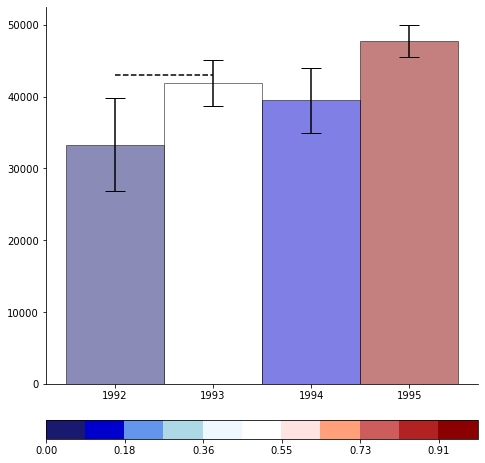

In [158]:
distributionBarChart(10, 43000.0, 0.95)

In [ ]:
import math
x = 463.6578
z = float(math.ceil(x / 100.0) * 100)
print(type(z))
print(z)

In [ ]:
200000/math.sqrt(3600)

In [ ]:
stats.t.ppf(1-.95/2, 3600)